<!-- # %% [markdown] -->
# 1. Generate diffraction simulations


4135627: 100%|██████████| 91/91 [00:01<00:00, 45.52it/s]
INFO - Generated 91 patterns.


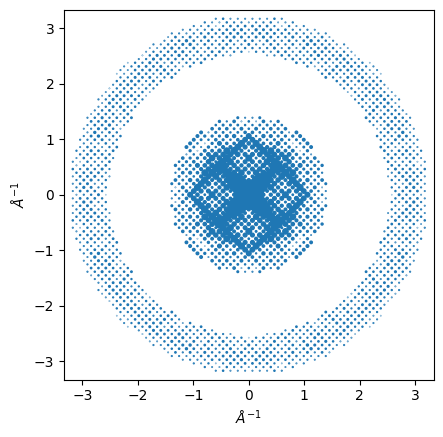

In [ ]:
# %%
from pathlib import Path
import logging

from orix.crystal_map import Phase
from orix.sampling import get_sample_reduced_fundamental
from diffsims.generators.simulation_generator import SimulationGenerator
from diffpy.structure import Lattice, Structure
from diffpy.structure.spacegroups import GetSpaceGroup

from parse_pdb_with_scale_remove_h import parse_pdb_with_scale

# ── user-tunable parameters ────────────────────────────────────────────────────         
# input = "/home/bubl3932/files/simulations/aP_lyso/lyso.pdb"        
# input = "/home/bubl3932/files/simulations/cF_Tl2Nb2O7/1000387.cif"              
# input = "/home/bubl3932/files/simulations/cI_Fe5O12Y3/1521848.cif"              
# input = "/home/bubl3932/files/simulations/cP_LTA/7108314.cif"              
# input = "/home/bubl3932/files/simulations/mC_CaMgO6Si2/1000007.cif"              
# input = "/home/bubl3932/files/simulations/mP_C3D3O7Sr/1000002.cif"           
# input = "/home/bubl3932/files/simulations/oA_CdCl2N2/9008053.cif"              
# input = "/home/bubl3932/files/simulations/oC_Cu3O21RbTa7/1001218.cif"              
# input = "/home/bubl3932/files/simulations/oF_Si2Ti/1009012.cif"              
# input = "/home/bubl3932/files/simulations/oI_GaLiO4Ti/1008839.cif"              
# input = "/home/bubl3932/files/simulations/oP_Cd2Zr3/2106134.cif"  

# input = "/home/bubl3932/files/simulations/MFM300-VIII_tI/4135627.cif"  

# input = "/Users/xiaodong/Desktop/simulations/C3O6Sr_mP/1000003.cif"   
# input = "/Users/xiaodong/Desktop/simulations/CuO2_oF/1521320.cif"
input = "/Users/xiaodong/Desktop/simulations/MFM300-VIII_tI/4135627.cif"
# input = "/Users/xiaodong/Desktop/simulations/LTA_cP/7108314.cif"
   
REF_PATH            = Path(input).expanduser()
RESOLUTION_DEG      = 10         # orientation sampling
MAX_RESOLUTION      = 0.3       # max simulated resolution in Å
DIRECT_BEAM         = False     # True = include direct beam, False = exclude direct beam
MAX_EXC_ERR_AINV    = 0.02      # max excitation error
SHAPE_FACTOR_W_AINV = 0.02      # shape factor. If None set to max excitation error
VOLTAGE_KV          = 300       # accelerating voltage in kV
# ───────────────────────────────────────────────────────────────────────────────

logging.basicConfig(level=logging.INFO, format="%(levelname)s - %(message)s")

if REF_PATH.suffix == ".pdb":
    cell, sg_sym, atoms = parse_pdb_with_scale(
        REF_PATH, remove_hydrogens=True, include_occupancy=False
    )
    phase = Phase(
        space_group=GetSpaceGroup(sg_sym),
        structure=Structure(atoms, Lattice(*cell))
    )
elif REF_PATH.suffix == ".cif":
    phase = Phase.from_cif(REF_PATH)
else:
    raise ValueError("Unsupported file format. Please provide a .pdb or .cif file.")

orientations = get_sample_reduced_fundamental(
    resolution=RESOLUTION_DEG, point_group=phase.point_group
)

generator = SimulationGenerator(
    accelerating_voltage=VOLTAGE_KV,
    shape_factor_model="linear", # "atanc", "sinc", "sin2c", "linear", "lorentzian" is default
    approximate_precession=False,
)

sims = generator.calculate_diffraction2d(
    phase               = phase,
    rotation            = orientations,
    reciprocal_radius   = 1/MAX_RESOLUTION,
    with_direct_beam    = DIRECT_BEAM,
    max_excitation_error= MAX_EXC_ERR_AINV,
    shape_factor_width  = SHAPE_FACTOR_W_AINV,
    debye_waller_factors= None,
    show_progressbar    = True,
)

sims.plot()
logging.info("Generated %d patterns.", sims.current_size)


<!-- # %% [markdown] -->
# 2. Write simulated patterns into HDF5 and helper files


In [2]:
# %%
import h5py
from tqdm import tqdm
from electron_wavelength import electron_wavelength
from clen_for_resolution import clen_for_dmin
from generate_cell import write_cell_file
from generate_geom import write_geom_file
from calculate_calibration import calculate_calibration
from create_empty_backgrounds import create_empty_backgrounds
from helper_functions_UB import copy_h5_file, get_next_simulation_folder
from compute_B import compute_B

# geometry / detector constants (edit if your setup changes)
# WAVELENGTH_A       = 0.019687                       # 0.019687 Å = 300 kV electron wavelength
WAVELENGTH_A       = electron_wavelength(VOLTAGE_KV)                     # 0.019687 Å = 300 kV electron wavelength
CLEN_M             = clen_for_dmin(MAX_RESOLUTION)  # camera length in meters
PIXELS_PER_M       = 17_857.14285714286             # corresponds to 56 µm/pixel size since 1/17857.14285714286 ≈ 56e-6 m
IN_PLANE_ANGLE_DEG = 180                            # matches .geom definitions
SIGMA_PIX          = 1
FAST_MODE          = False
NORMALISE          = True
FAST_CLIP_TH       = 1e-12
INTENSITY_SCALE    = 10_000

# ── derived paths ─────────────────────────────────────────────────────────────
working_dir  = REF_PATH.parent
create_empty_backgrounds(working_dir, sims.current_size)
empty_h5     = working_dir / f"{sims.current_size}_empty_backgrounds.h5"

sim_folder   = get_next_simulation_folder(working_dir)
sim_folder.mkdir(exist_ok=True)

cell_path    = sim_folder / f"{REF_PATH.stem}.cell"
geom_path    = sim_folder / f"{REF_PATH.stem}.geom"
h5_path      = sim_folder / "sim.h5"
sol_path     = sim_folder / "orientation_matrices.sol"
# ──────────────────────────────────────────────────────────────────────────────

# write helper files ----------------------------------------------------------
centering   = phase.space_group.short_name[0].upper()
if centering == "A" or centering == "C":
    centering = "S"

write_cell_file(
    {
        "lattice_type": phase.space_group.crystal_system.lower(),
        "centering"   : centering,
        "a"           : phase.structure.lattice.a,
        "b"           : phase.structure.lattice.b,
        "c"           : phase.structure.lattice.c,
        "alpha"       : phase.structure.lattice.alpha,
        "beta"        : phase.structure.lattice.beta,
        "gamma"       : phase.structure.lattice.gamma,
    },
    cell_path
)
write_geom_file(geom_path, wavelength=WAVELENGTH_A, clen=CLEN_M, res=PIXELS_PER_M)

copy_h5_file(empty_h5, h5_path)

calibration = calculate_calibration(
    wavelength_A=WAVELENGTH_A, clen_m=CLEN_M, res=PIXELS_PER_M
)
B_mat = compute_B(
    (
        phase.structure.lattice.a,
        phase.structure.lattice.b,
        phase.structure.lattice.c,
        phase.structure.lattice.alpha,
        phase.structure.lattice.beta,
        phase.structure.lattice.gamma,
    )
)

# update HDF5 in-place ---------------------------------------------------------
with h5py.File(h5_path, "r+", libver="latest") as f:
    imgs = f["entry/data/images"]
    ori  = f["entry/data"].require_dataset(
        "simulation_orientation_matrices",
        shape=(imgs.shape[0], 3, 3),
        dtype=float,
    )
    det_shift_x_mm = f["entry"]["data"].require_dataset(
    "det_shift_x_mm",
    shape=(imgs.shape[0],),
    dtype=float,
    fillvalue=0
    )
    det_shift_y_mm = f["entry"]["data"].require_dataset(
    "det_shift_y_mm",
    shape=(imgs.shape[0],),
    dtype=float,
    fillvalue=0
    )
    
    shape = imgs.shape[-2:]
    beam_pos = (shape[0] // 2, shape[1] // 2)
    # store run metadata as attributes instead of a loose TXT
    meta = f["entry"].attrs
    meta.update(
        ref_file           = str(REF_PATH),
        resolution_deg     = RESOLUTION_DEG,
        max_resolution     = MAX_RESOLUTION,
        direct_beam        = DIRECT_BEAM,
        beam_position      = beam_pos,
        max_excitation_err = MAX_EXC_ERR_AINV,
        shape_factor_width = SHAPE_FACTOR_W_AINV,
        voltage_kV         = VOLTAGE_KV,
        wavelength_A       = WAVELENGTH_A,
        clen_m             = CLEN_M,
        pixels_per_m       = PIXELS_PER_M,
        calibration        = calibration,
        in_plane_angle_deg = IN_PLANE_ANGLE_DEG,
        sigma_pix          = SIGMA_PIX,
        fast_mode          = FAST_MODE,
        normalise          = NORMALISE,
        fast_clip_th       = FAST_CLIP_TH,
        intensity_scale    = INTENSITY_SCALE,
    )


    for i in tqdm(range(imgs.shape[0]), desc="Writing patterns"):
        pattern = sims.irot[i].get_diffraction_pattern(
            shape               = shape,
            direct_beam_position= beam_pos,
            in_plane_angle      = IN_PLANE_ANGLE_DEG,
            sigma               = SIGMA_PIX,
            calibration         = calibration,
            fast                = FAST_MODE,
            normalize           = NORMALISE,
            fast_clip_threshold = FAST_CLIP_TH,
        )
        imgs[i] += (pattern * INTENSITY_SCALE).astype(imgs.dtype)
        ori[i]   = B_mat @ sims.rotations[i].to_matrix().squeeze()

# write .sol -------------------------------------------------------------------

LAT_CODE = {
    'triclinic':'a','monoclinic':'m','orthorhombic':'o',
    'tetragonal':'t','rhombohedral':'h','hexagonal':'h','cubic':'c'
}

AXIS_MAP = {
'monoclinic':    'b',
'tetragonal':    'c',
'hexagonal':     'c',
'trigonal':      'c',
'rhombohedral':  'c',
# orthorhombic, cubic, triclinic → no unique_axis entry
}

unique = AXIS_MAP.get(phase.space_group.crystal_system.lower())
if unique:
    bravais = f"{LAT_CODE[phase.space_group.crystal_system.lower()]}{centering}{unique}"
else:
    bravais = f"{LAT_CODE[phase.space_group.crystal_system.lower()]}{centering}"

with h5py.File(h5_path, "r") as fh:
    ori = fh["entry/data/simulation_orientation_matrices"][:]  # ← ndarray copy

with open(sol_path, "w") as fh:
    for idx, m in enumerate(ori):
        line = " ".join(f"{v:+.7f}" for v in m.flatten())
        fh.write(f"{h5_path} //{idx} {line} 0.000 0.000 {bravais}\n")

logging.info("All files written to %s", sim_folder)


→ Wrote /Users/xiaodong/Desktop/simulations/MFM300-VIII_tI/sim_004/4135627.cell
→ Wrote /Users/xiaodong/Desktop/simulations/MFM300-VIII_tI/sim_004/4135627.geom


Writing patterns: 100%|██████████| 1657/1657 [01:10<00:00, 23.52it/s]
INFO - All files written to /Users/xiaodong/Desktop/simulations/MFM300-VIII_tI/sim_004


<!-- # %% [markdown] -->
# 3. Run Gandalf integration from the generated .sol


In [ ]:
# %%
from gandalf_iterator import gandalf_iterator

extra_flags = [
    "--no-revalidate", "--no-half-pixel-shift",
    "--peaks=peakfinder9",
    "--indexing=file", f"--fromfile-input-file={sol_path}",
    "--no-check-cell", "--no-check-peaks", "--no-retry", "--no-refine",
    "--integration=rings", "--int-radius=4,5,7",
    "--no-non-hits-in-stream", "--fix-profile-radius=70000000",
]
cell_path = str(cell_path)
geom_path = str(geom_path)
gandalf_iterator(
    geomfile_path       = geom_path,
    cellfile_path       = cell_path,
    input_path          = sim_folder,
    output_file_base    = "from_file",
    num_threads         = 24,
    x                   = 512.5,   # beam centre in pixels
    y                   = 512.5,
    step                = 0.5,
    layers              = 0,
    extra_flags         = extra_flags,
)
logging.info("Gandalf integration finished.")
